In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Ham verinin görselleştirilmesi

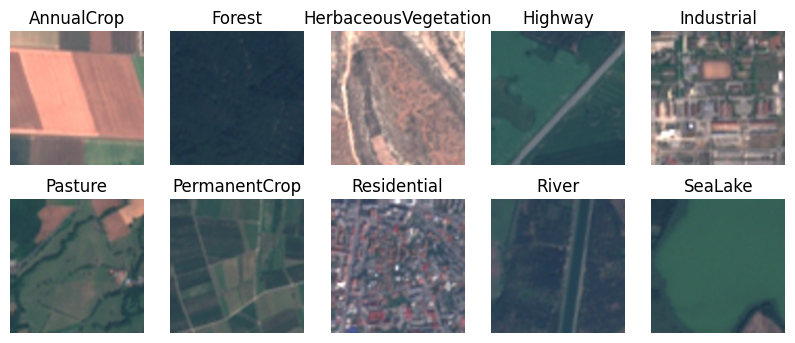

In [ ]:

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to the root directory of your test dataset
data_dir = r"/content/drive/MyDrive/DeepLearningProject/EuroSAT_RGB_sample2/test"

# Define the list of categories in your dataset
categories = ['AnnualCrop',
              'Forest', 
              'HerbaceousVegetation', 
              'Highway', 
              'Industrial', 
              'Pasture', 
              'PermanentCrop', 
              'Residential', 
              'River', 
              'SeaLake']

# Initialize a figure object and set the size of the figure
fig = plt.figure(figsize=(10, 4))

# Loop over the categories and plot one random image from each category in a subplot
for i, category in enumerate(categories):
    # Set the path to the category directory
    category_dir = os.path.join(data_dir, category)
    # Get a list of all image files in the category directory
    image_files = [os.path.join(category_dir, f) for f in os.listdir(category_dir) if f.endswith(('.jpg' ))]
    # Choose a random image from the category
    image_path = random.choice(image_files)
    # Open the image with PIL
    image = Image.open(image_path)
    # Resize the image to 256x256
    image = image.resize((256, 256))
    # Convert the image to a NumPy array
    image_array = np.asarray(image)
    # Add the image to the subplot
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.imshow(image_array)
    subplot.set_title(category)
    subplot.axis('off')

# Show the plot
plt.show()


## Verinin çoğaltılması (augmentation)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with the desired data augmentation options
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Define the ImageDataGenerator for the validation set (only rescale the pixel values)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Define the ImageDataGenerator for the test set (only rescale the pixel values)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size and image size for the generators
batch_size = 32
img_size = (64, 64)

# Define the directories for the training, validation, and test sets
train_dir =  r"/content/drive/MyDrive/DeepLearningProject/EuroSAT_RGB_sample2/train"
val_dir =  r"/content/drive/MyDrive/DeepLearningProject/EuroSAT_RGB_sample2/val"
test_dir =  r"/content/drive/MyDrive/DeepLearningProject/EuroSAT_RGB_sample2/test"



## Flow_from_directory ile klasör isimlerinden sınıfların belirlenmesi

flow_from_directory() metodu, bir dizin yolunu belirterek klasörler içindeki görüntüleri ve etiketleri otomatik olarak yükleyebilir. batch_size parametresi ile belirtilen boyutlarda örnekler üretir. Artırılmış veri örnekleri, her bir epoch için yeniden oluşturulur ve eğitim veri setine eklenir. Bu nedenle, model eğitimi sırasında daha fazla veri örneği kullanılabilir ve aşırı öğrenme riski azaltılabilir.

In [3]:
# Create the generators for the training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')


Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


## Multilayer Perceptron Model Kurulması

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers
#regularizers
from tensorflow.keras.layers import Dropout # one of the best regularizers
from tensorflow.keras.regularizers import l1,l2,l1_l2
#optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Ftrl


## ML Model Mimarisinin Regülasyon Yöntemleriyle Kurulması
 


In [7]:
import tensorflow as tf

model1 = Sequential()
model1.add(Flatten(input_shape = (64,64, 3)))  # 0 input layer
model1.add(Dense(1000,activation='relu' ,  
               kernel_regularizer=l2(0.005),bias_regularizer=l2(0.005)
                ))  # relu layer 1.  #     kernel_regularizer=l1_l2(),bias_regularizer=l2() 

model1.add(Dense(500,activation='relu' ,  
               kernel_regularizer=l2(0.005),bias_regularizer=l2(0.005)
                ))  # relu layer 1.  #     kernel_regularizer=l1_l2(),bias_regularizer=l2() 

model1.add(Dropout(rate=0.3))
model1.add(Dense(100,activation='relu',kernel_regularizer=l2(l=0.005),bias_regularizer=l2(1e-3)   )) 
model1.add(Dense(50,activation='relu',kernel_regularizer=l2(l=0.005),bias_regularizer=l2(1e-2)  )) 
model1.add(Dropout(rate=0.3))
model1.add(Dense(10,activation='softmax', kernel_regularizer=l2(l=0.005), bias_regularizer=l2(1e-2)   )) 



# early stopping
earlystopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
# ReduceLROnPlateau callback
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,min_lr = 0.0005, patience=2,verbose=1)

##Model checkpointing callback
ckpt_path = '/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/model_ckpt.h5' 
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only = True)

#List the callbacks 
callbacks=[rlronp, earlystopCB, ckpt_cb]



model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 1000)              12289000  
                                                                 
 dense_6 (Dense)             (None, 500)               500500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               50100     
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)               

In [33]:


model1.compile(optimizer="adam",loss='categorical_crossentropy' ,metrics=['accuracy' ])   

In [34]:
history1 = model1.fit(train_generator, epochs=40, validation_data=val_generator, callbacks=callbacks)



Epoch 1/40
250/250 [==============================] - 32s 120ms/step - loss: 5.2436 - accuracy: 0.1184 - val_loss: 3.2958 - val_accuracy: 0.1400 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - 31s 125ms/step - loss: 2.8886 - accuracy: 0.2136 - val_loss: 2.8729 - val_accuracy: 0.1450 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - 31s 123ms/step - loss: 2.5547 - accuracy: 0.2503 - val_loss: 2.4179 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - 30s 121ms/step - loss: 2.3535 - accuracy: 0.2652 - val_loss: 2.1880 - val_accuracy: 0.3270 - lr: 0.0010
Epoch 5/40
250/250 [==============================] - 31s 126ms/step - loss: 2.2092 - accuracy: 0.2856 - val_loss: 2.1048 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 6/40
250/250 [==============================] - 32s 129ms/step - loss: 2.1643 - accuracy: 0.2907 - val_loss: 2.0349 - val_accuracy: 0.3210 - lr: 0.0010
Epoch 7/40
250/250 [==============================] 

## Doğruluk ve Kayıp Grafiklerinin Eğitim ve Doğrulama Verikümeleriyle Gösterimi

In [ ]:
#Accuracy ve Loss Grafiğini Göster
def tr_plot(tr_data, start_epoch):
    #training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

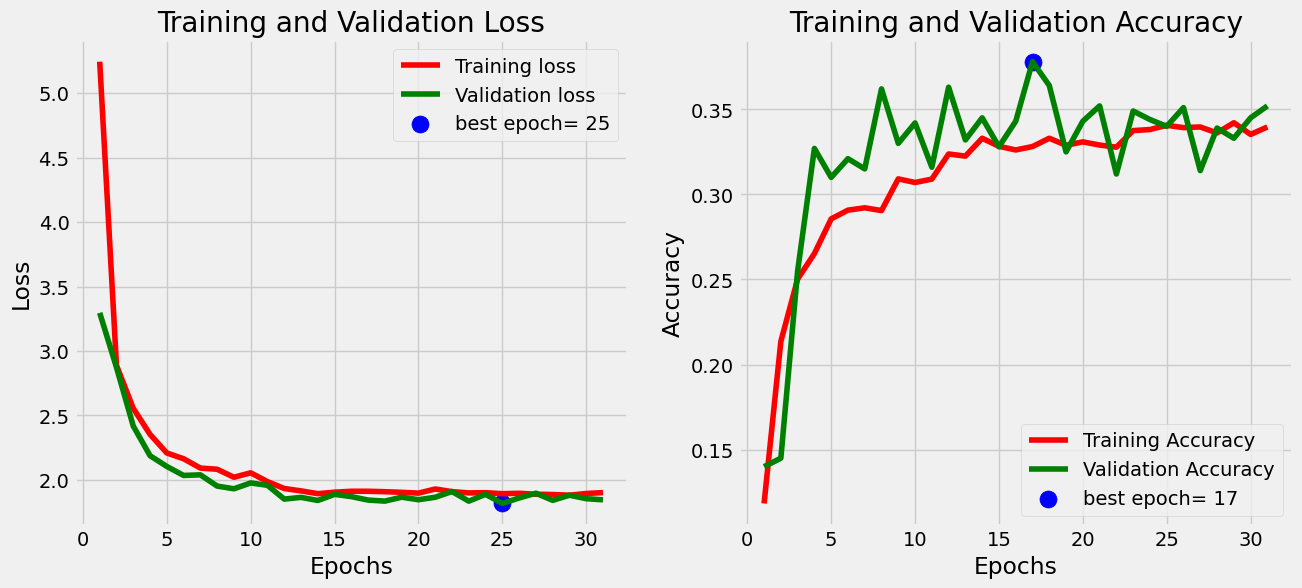

In [35]:
    
tr_plot(history1,0)


In [ ]:
model1.evaluate(test_generator)

##  MLModelin kaydedilmesi

In [ ]:
model_clf.save('/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/ml1model.h5')

## Eniyi modelin geriçağırma ile yeniden yüklenmesi

In [8]:
bestmodel_checkpointcallback = tf.keras.models.load_model(ckpt_path)

## Bazı görüntülerin model tahminleri ve gerçek etiketlerinin beraber görselleştirilmesi

In [ ]:
# make predictions
def pred_real_visualize(test_dataset, model):
  # iterate over the test dataset batches
  for dataset in iter(test_dataset):
      # unpack a single batch of images and labels
      image_batch, label_batch = dataset

      # make predictions on test dataset
      y_prob = model.predict(dataset, verbose=1)

      # visualize 10 images from dataset
      plt.figure()
      for i in range(10):
          # retrieve ith image from current batch and show
          ax = plt.subplot(2, 5, i + 1)
          image = image_batch[i].numpy().astype("uint8")
          plt.imshow(image)
          plt.axis("off")  # turn off axis for clarity

          # index of highest probability indicates predicted class
          y_class = y_prob[i].argmax()

          # display image title with actual and predicted labels
          plt.title(f'Actual: {class_names[label_batch[i]][:10]},'
                    f'\nPredicted: {class_names[y_class][:10]}')

pred_real_visualize(test_generator, bestmodel_checkpointcallback)

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def conf_matrix(test_generator, model):
  y_pred = []  # store predicted labels
  y_true = []  # store true labels
  
  # iterate over the dataset
  for i, (image_batch, label_batch) in enumerate(test_generator):   # use dataset.unbatch() with repeat
      # append true labels
      y_true.append(label_batch)
      # compute predictions
      preds = model.predict(image_batch)
      # append predicted labels
      y_pred.append(np.argmax(preds, axis =  1))
      if i==300:
          break

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  correct_labels = np.argmax(correct_labels, axis=1)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)
  cm = confusion_matrix(correct_labels, predicted_labels)
  return cm

In [14]:

conf_matrix(test_generator, bestmodel_checkpointcallback)

1/1 [==============================] - 0s 45ms/step


array([[434,   8,   0,  10, 251,  49,  84,  56,  47,   0],
       [  0, 734,   0,   0,   0, 138,   0,   9,   0, 113],
       [143,  19,   0,   0, 499,  48, 130,  50,  19,   0],
       [ 66,  27,   0,  18, 284, 233,  20, 126,  57,   0],
       [ 68,   0,   0,  20, 802,   9,  19,  49,  20,   0],
       [  0, 156,   0,  28,  95, 498,   0,  62,  83,   0],
       [378,   0,   0,  20, 300,  26, 142,  62,  19,   0],
       [113,  19,   0,  20, 524,  58,  62, 216,  55,   0],
       [ 20, 113,   0,  35, 149, 562,  10,  77,  87,  28],
       [  0, 147,   0,  29,  64, 104,   0,  29,  30, 337]])

In [ ]:
!pip install itertools
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Oranolarak confusion matrix")
    else:
        print('Confusion matrix, rakamsal olarak')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
Confusion matrix, without normalization
[[434   8   0  10 251  49  84  56  47   0]
 [  0 734   0   0   0 138   0   9   0 113]
 [143  19   0   0 499  48 130  50  19   0]
 [ 66  27   0  18 284 233  20 126  57   0]
 [ 68   0   0  20 802   9  19  49  20   0]
 [  0 156   0  28  95 498   0  62  83   0]
 [378   0   0  20 300  26 142  62  19   0]
 [113  19   0  20 524  58  62 216  55   0]
 [ 20 113   0  35 149 562  10  77  87  28]
 [  0 147   0  29  64 104   0  29  30 337]]


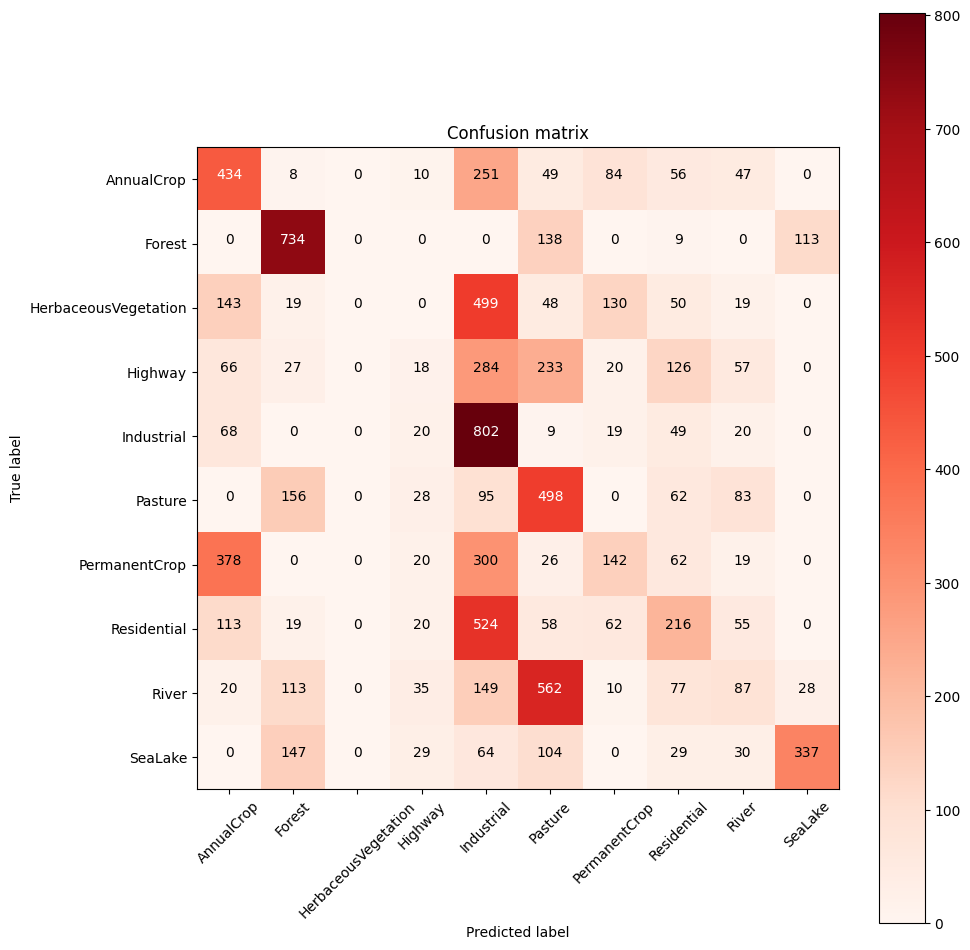

In [20]:
## Call the function    
plot_confusion_matrix(cm, test_generator.class_indices, cmap='Reds')

In [ ]:
## an alternative way to show confusion matrix as a heatmap
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y, y_pred)

print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

## Model mimarisinin görselleştirilmesi

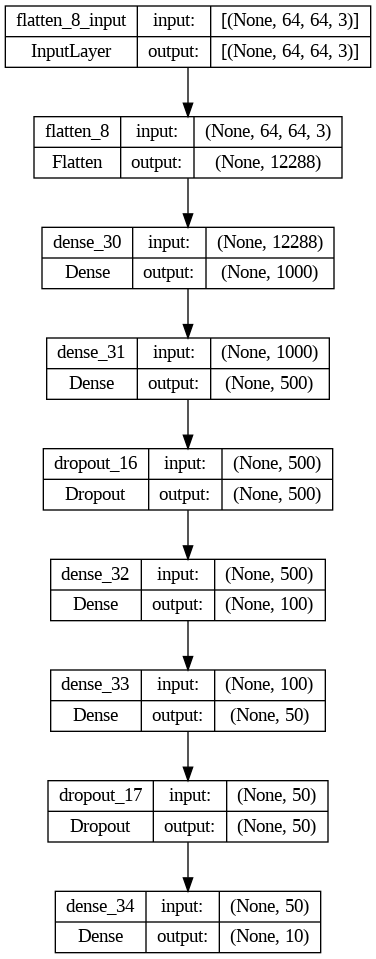

In [16]:
tf.keras.utils.plot_model(bestmodel_checkpointcallback, "multi_input_and_output_model.png", show_shapes=True)

## ML Model Mimarisinin Regülasyon Yöntemleri Olmadan Kurulması

In [5]:
import tensorflow as tf

model2 = Sequential()
model2.add(Flatten(input_shape = (64,64, 3)))  # 0 input layer
model2.add(Dense(1000,activation='relu'  ))  
model2.add(Dense(500,activation='relu'))  
##model2.add(Dropout(rate=0.3))
model2.add(Dense(100,activation='relu'  )) 
model2.add(Dense(50,activation='relu' )) 
##model2.add(Dropout(rate=0.3))
model2.add(Dense(10,activation='softmax')) 


model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 1000)              12289000  
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 100)               50100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
Total params: 12,845,160
Trainable params: 12,845,160
No

In [6]:
model2.compile(optimizer="adam",loss='categorical_crossentropy' ,metrics=['accuracy' ])   

In [ ]:
history2 = model2.fit(train_generator, epochs=40, validation_data=val_generator)


Epoch 1/40
 70/250 [=======>......................] - ETA: 27:04 - loss: 2.7942 - accuracy: 0.1187

In [ ]:
model2.save('/content/drive/MyDrive/DeepLearningProject/ModelCallbacks/ml2model.h5')

## CNN denemesi

In [ ]:
# build tensorflow sequential convolutional neural network model

model = Sequential([

    # layer 1 - preprocessing layer with convolution and max pooling
    # rescaling_layer,
    layers.Conv2D(filters=8, kernel_size=3, padding='same',
                  activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),

    # layer 2 - convolutional layer and max pooling
    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 3 - convolutional layer and max pooling
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    layers.Dropout(rate=0.2),

    # layer 4 - convolutional layer and max pooling
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    layers.Dropout(rate=0.2),
    layers.Flatten(),

    # layer 5 - dense fully connected layer
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(rate=0.3),
    # layer 6 - output dense layer
    layers.Dense(units = 10)
])

# compile tensorflow sequential CNN model
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# print model summary
model.summary()

## Modelin görselleştirilmesi

In [17]:
!pip install visualkeras
import visualkeras

model = bestmodel_checkpointcallback

visualkeras.layered_view(model).show() # display using your system viewer
#visualkeras.layered_view(model, to_file='output.png') # write to disk
#visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 13.6 MB/s eta 0:00:00
